In [1]:
import pandas as pd
import sklearn.cross_decomposition
import sklearn.linear_model
import matplotlib.pyplot as plt
import seaborn

import sp_project.app_state
from sp_project.notebook_tools import default_clients
import sp_project.data_preparation.db_entsoe as entsoe_data
import sp_project.data_preparation.db_wetter2 as wetter2_data
from sp_project.data_preparation.solar_power import total_solarpower_below_clouds

%matplotlib inline

## Collect and prepare the Data

<b>Units:</b><br>
temperature : celsius<br>
rain : mm<br>
wind : m/s<br>
cloud : percent<br>

In [6]:
async with default_clients() as (OWclient, db):
    app_state = sp_project.app_state.AppState(ow_client=OWclient, db_client=db)
    
    daily_data = await wetter2_data.extract_data_daily(app_state)
    heating_demand = await wetter2_data.extract_heatingdemand(app_state)
    windpower = await wetter2_data.extract_windpower(app_state)
    energy_data = await entsoe_data.extract_energy_data_daily(app_state)
    
solar_power = total_solarpower_below_clouds(daily_data, 47)

In [7]:
input_features = [heating_demand, windpower, daily_data.rain, solar_power.rename("solar_power")]
input_features = pd.concat(input_features, axis="columns")

In [8]:
target_features = energy_data

## Analyse Data with Linear Regression

### Daily Data

In [9]:
valid_input_features_daily = input_features.dropna(axis="index", how='any').index
valid_target_features_daily = target_features.dropna(axis="index", how='any').index
joined_index = valid_input_features_daily.intersection(valid_target_features_daily)

/Users/missd/.pyenv/versions/3.11.4/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


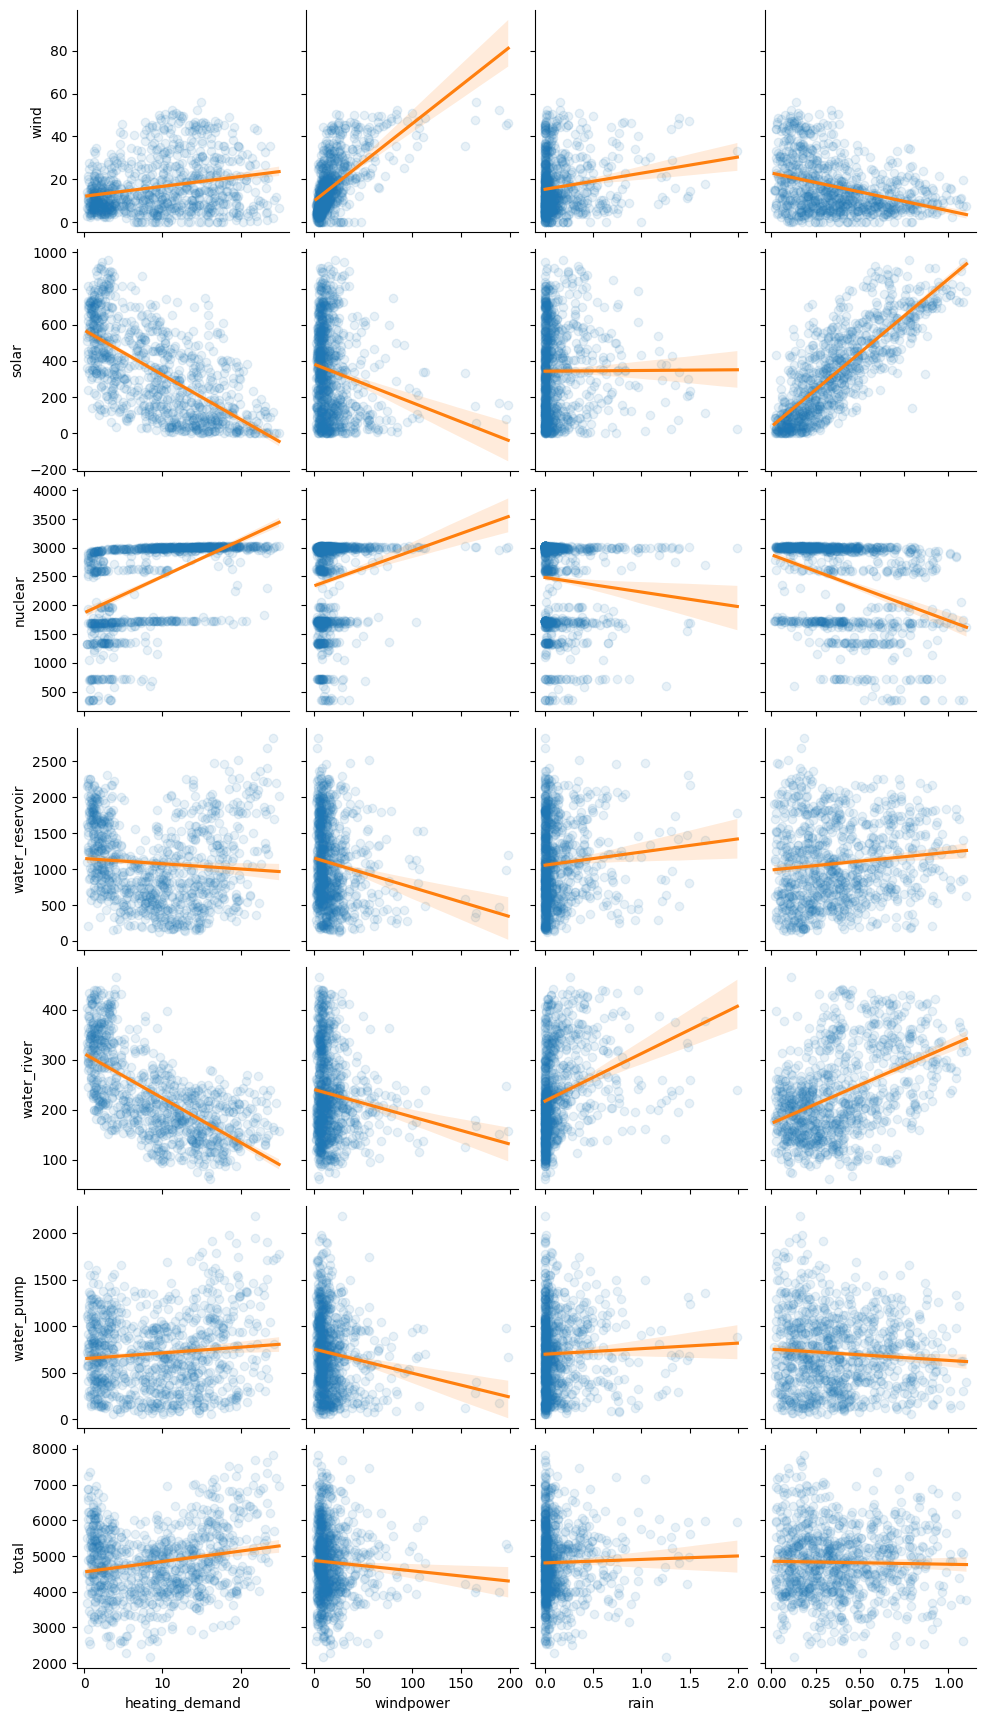

In [10]:
seaborn.pairplot(
    data=pd.concat([input_features, target_features],axis="columns"),
    x_vars=input_features.columns,
    y_vars=target_features.columns,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.1,
        ),
        line_kws=dict(color='tab:orange'),
    )
)

#### Regression Solar-Energy and Sunshine

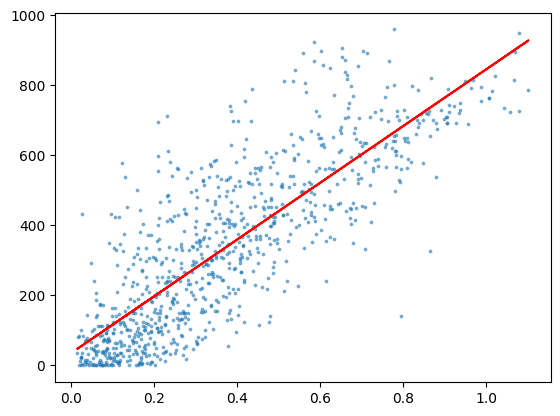

In [11]:
X = input_features.solar_power[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.solar[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

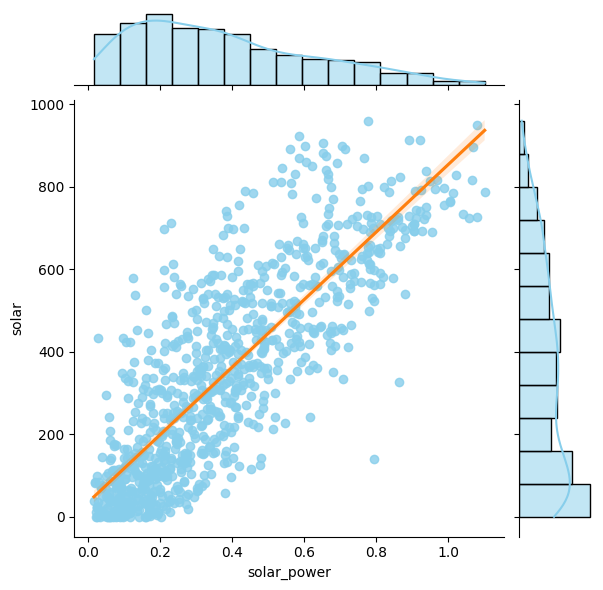

In [12]:
seaborn.jointplot(
    x=input_features.solar_power, 
    y=target_features.solar,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

#### Regression Wind-Energy and Wind

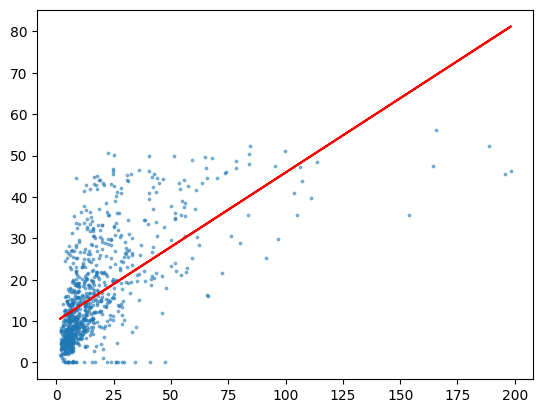

In [13]:
X = input_features.windpower[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.wind[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

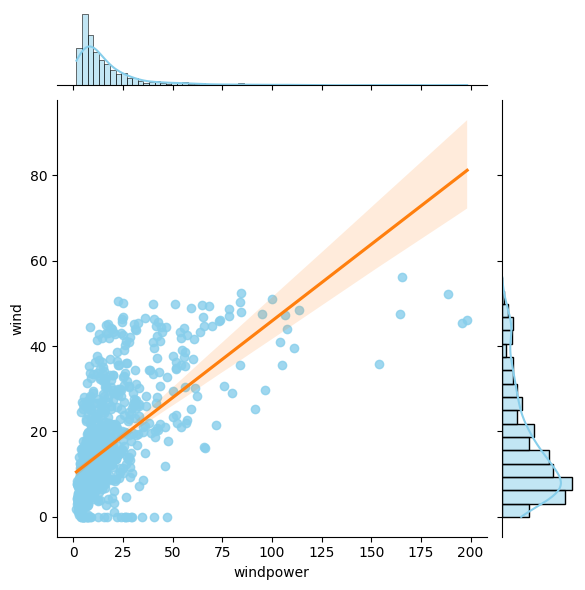

In [14]:
seaborn.jointplot(
    x=input_features.windpower, 
    y=target_features.wind,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

#### Regression Water-River-Energy and Rain

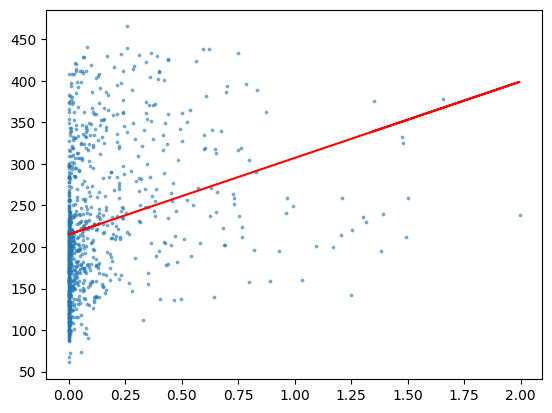

In [15]:
X = input_features.rain[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.water_river[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

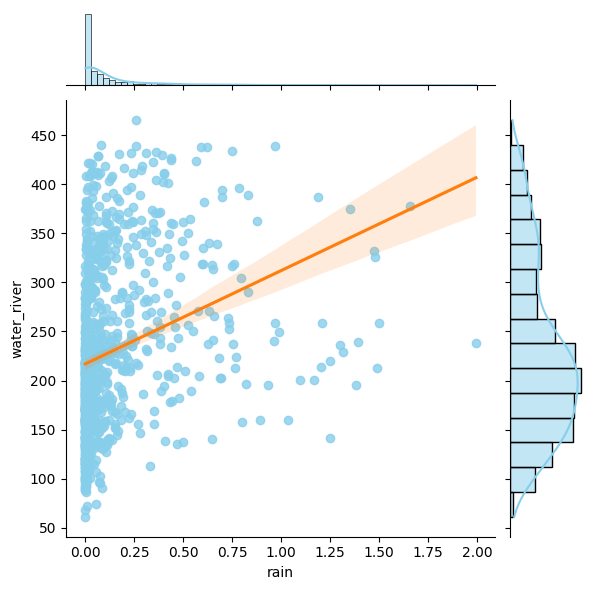

In [16]:
seaborn.jointplot(
    x=input_features.rain, 
    y=target_features.water_river,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

#### Regression Nuclear-Energy and Heating Demand

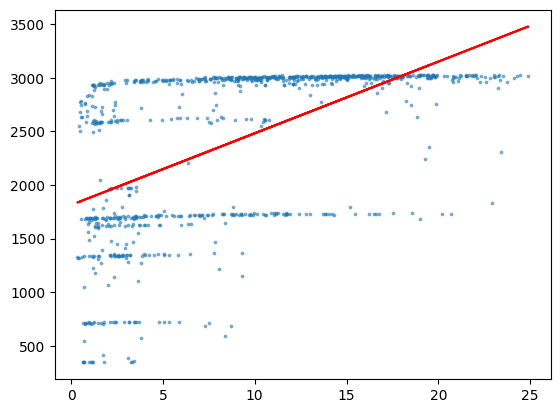

In [17]:
X = input_features.heating_demand[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.nuclear[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

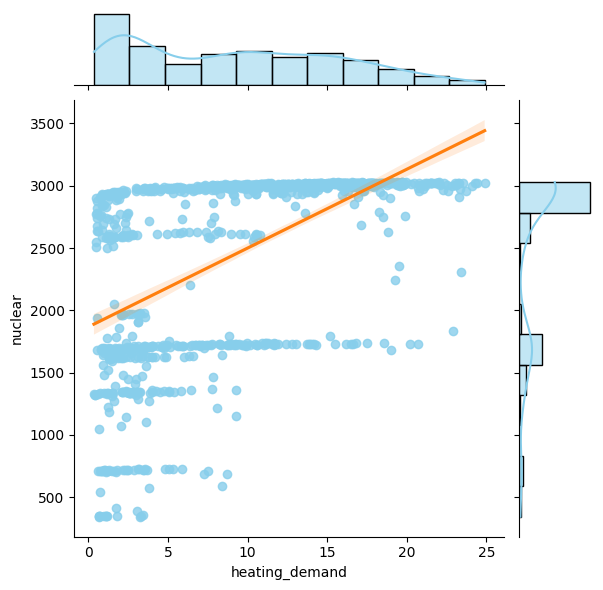

In [18]:
seaborn.jointplot(
    x=input_features.heating_demand, 
    y=target_features.nuclear,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

### Weekly Data

In [19]:
input_features_weekly = input_features.resample('W').mean()
target_features_weekly = target_features.resample('W').mean()

In [20]:
valid_input_features_weekly = input_features.dropna(axis="index", how='any').index
valid_target_features_weekly = target_features.dropna(axis="index", how='any').index

/Users/missd/.pyenv/versions/3.11.4/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


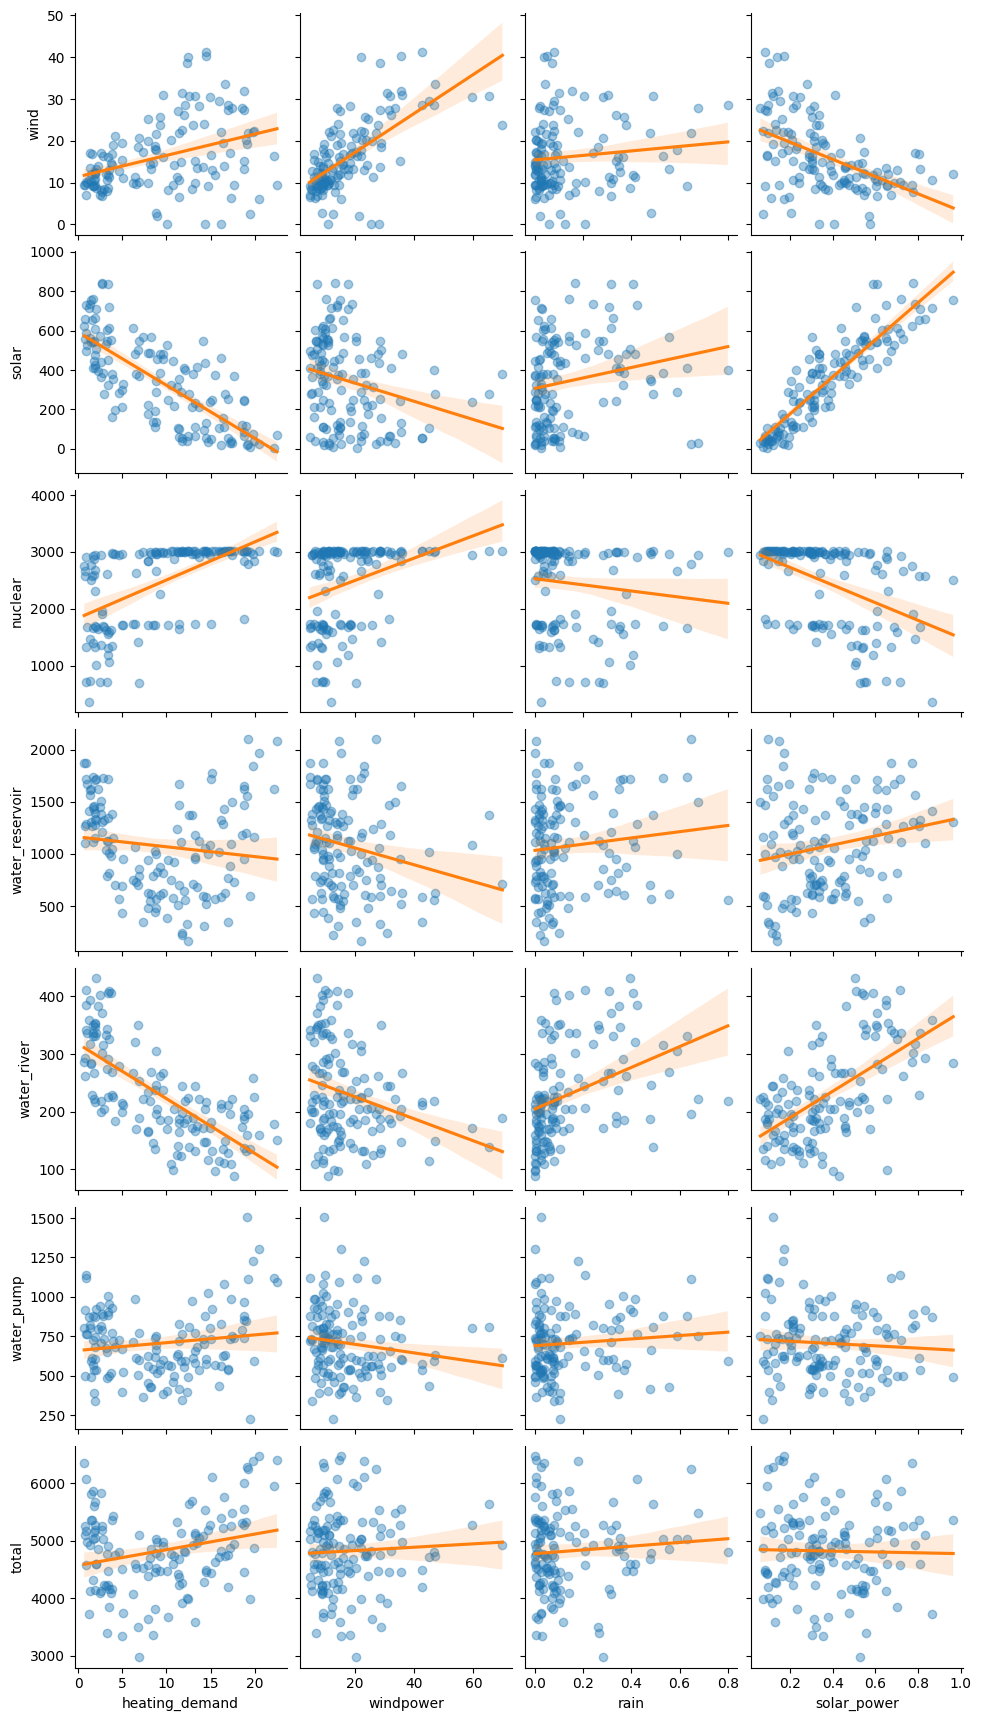

In [21]:
regression_overview = seaborn.pairplot(
    data=pd.concat([input_features_weekly, target_features_weekly],axis="columns"),
    x_vars=input_features_weekly.columns,
    y_vars=target_features_weekly.columns,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.4,
        ),
        line_kws=dict(color='tab:orange'),
    )
)


In [22]:
regression_overview.savefig("../../src/sp_project/backend_server/static/pictures/regression-overview.png")

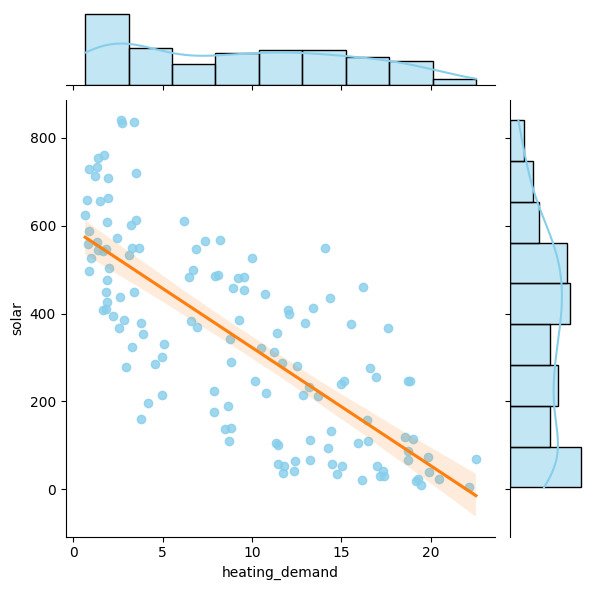

In [23]:
seaborn.jointplot(
    x=input_features_weekly.heating_demand, 
    y=target_features_weekly.solar,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

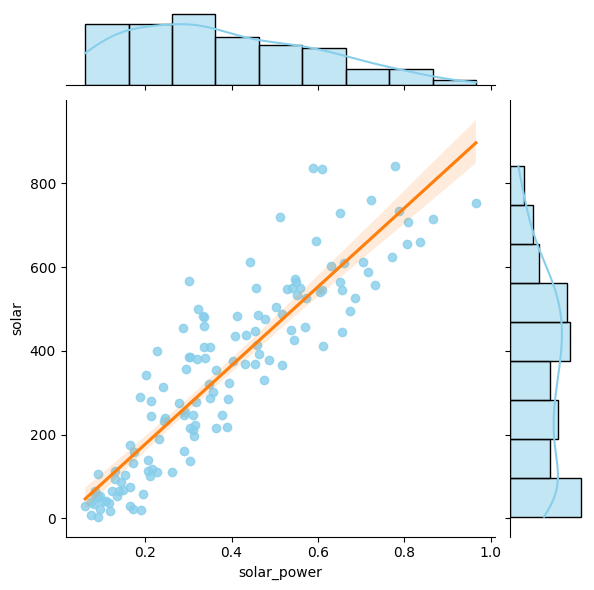

In [24]:
seaborn.jointplot(
    x=input_features_weekly.solar_power, 
    y=target_features_weekly.solar,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

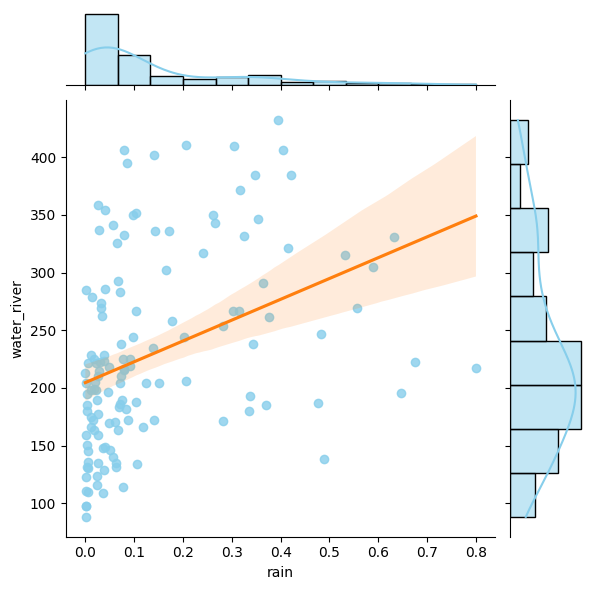

In [25]:
seaborn.jointplot(
    x=input_features_weekly.rain, 
    y=target_features_weekly.water_river,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

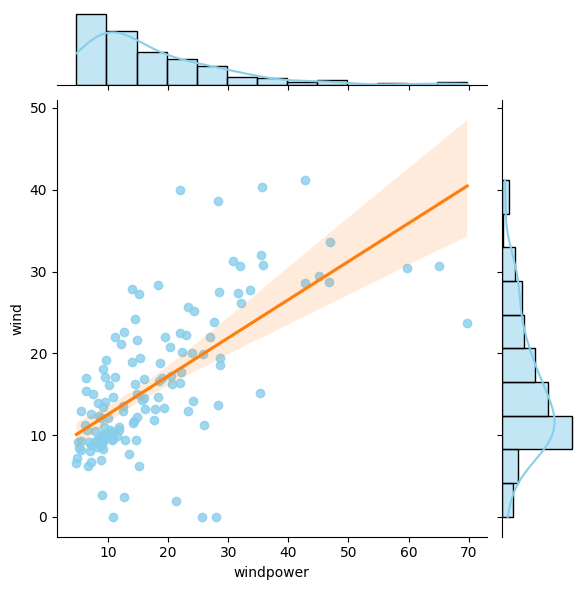

In [26]:
seaborn.jointplot(
    x=input_features_weekly.windpower, 
    y=target_features_weekly.wind,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

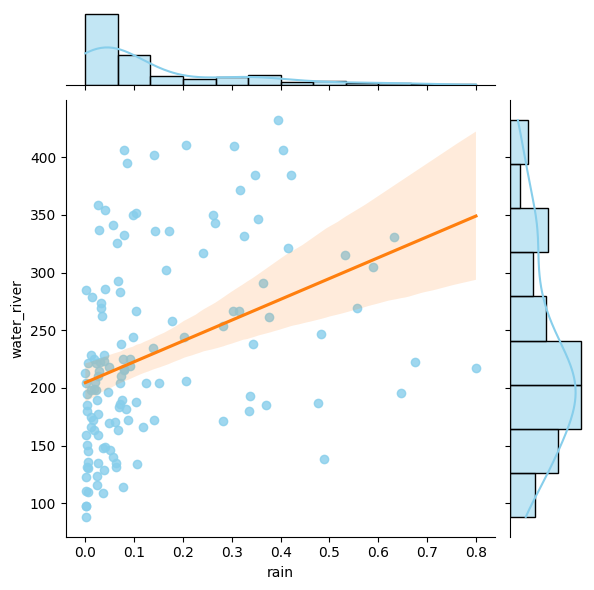

In [27]:
seaborn.jointplot(
    x=input_features_weekly.rain, 
    y=target_features_weekly.water_river,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

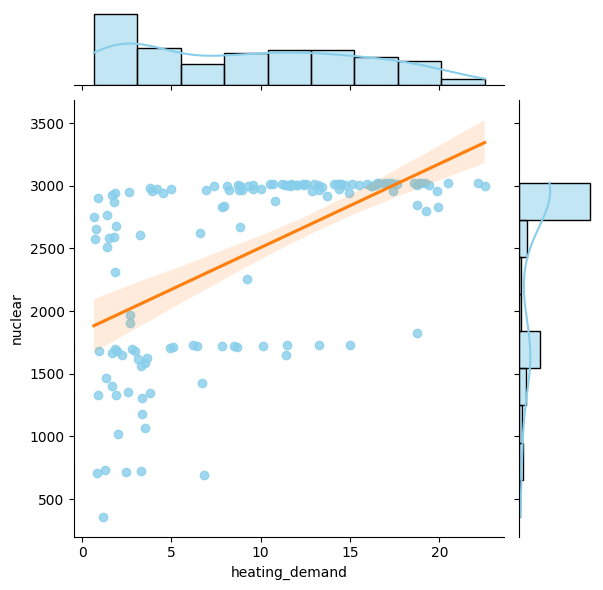

In [28]:
seaborn.jointplot(
    x=input_features_weekly.heating_demand, 
    y=target_features_weekly.nuclear,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

### PLS-Regression with weekly data

In [29]:
input_features_weekly = input_features.resample('W').mean()
target_features_weekly = target_features.resample('W').mean()

valid_input_features_weekly = input_features_weekly.dropna(axis="index", how='any').index
valid_target_features_weekly = target_features_weekly.dropna(axis="index", how='any').index

joined_index = valid_input_features_weekly.intersection(valid_target_features_weekly)
joined_index = joined_index[joined_index.year == 2021]  # fit model in 2021 and verify in 2022

pls2 = sklearn.cross_decomposition.PLSRegression(n_components=2)

pls2 = pls2.fit(
    input_features_weekly.loc[joined_index,:], 
    target_features_weekly.loc[joined_index,:],
)

### Prediction Coefficients (Regression Coefficients)

In [33]:
regression_coefficients = pd.DataFrame(
    data = pls2.coef_,
    index = target_features_weekly.columns,
    columns = input_features_weekly.columns,
)
regression_coefficients

,heating_demand,windpower,rain,solar_power
wind,1.662335,2.058109,1.855716,-1.469950
solar,-71.574544,-24.370082,50.924740,67.708805
nuclear,248.451679,163.605140,-15.877475,-229.599746
water_reservoir,-31.295815,8.784012,61.852916,30.942274
water_river,-26.731438,-2.609766,32.238983,25.734078
water_pump,-15.568222,10.563840,43.382523,15.818285
total,104.943995,158.031253,174.377404,-90.866253


In [34]:
x_weights = round(pd.DataFrame(index=input_features_weekly.columns, data=pls2.x_weights_), 3)
x_weights.index.name = "Weather Features"

In [35]:
y_weights = round(pd.DataFrame(index=target_features_weekly.columns, data=pls2.y_weights_), 3)
y_weights.index.name = "Energy Features"

### Prediction with the input_features of the year 2021 and 2022

In [36]:
prediction = pls2.predict(input_features.loc[:,input_features.columns])
prediction = pd.DataFrame(prediction, index = input_features.index,columns=target_features.columns)
prediction_weekly = prediction.resample('W').mean()

Text(0.5, 1.0, 'Prediction: Energy Production predicted from Weather')

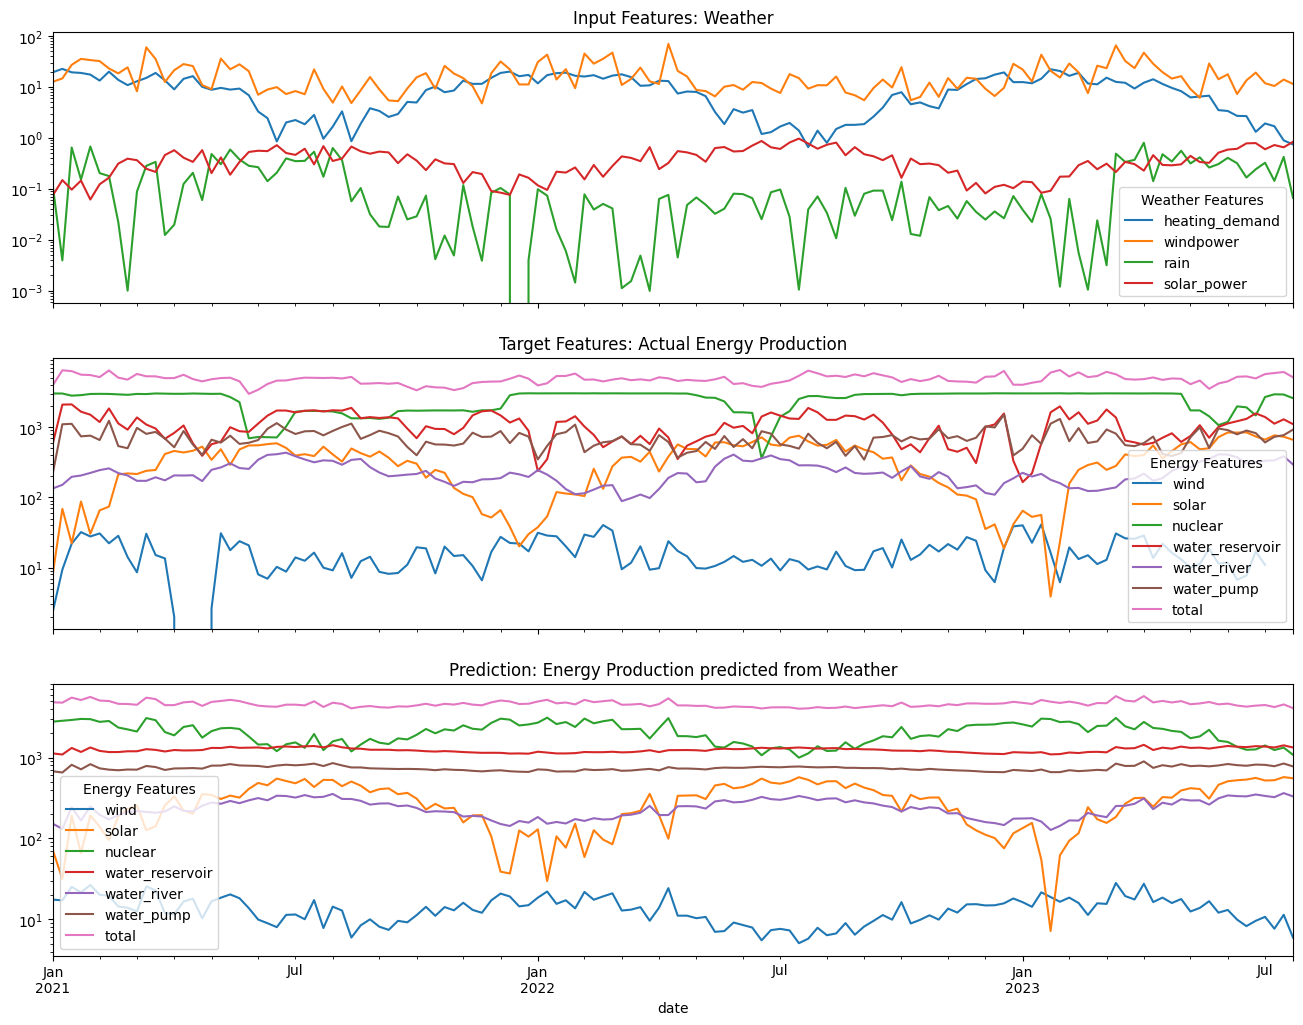

In [37]:
fig,axes = plt.subplots(3,1,figsize=(16,12),sharex=True)

ax = axes[0]
input_features_weekly.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Input Features: Weather")

ax = axes[1]
target_features_weekly.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Target Features: Actual Energy Production")


ax = axes[2]
prediction_weekly.plot(ax=ax)
ax.set_yscale("log")
ax.set_title("Prediction: Energy Production predicted from Weather")

### Superimposing with predicted Production and actual Production per Production-Type

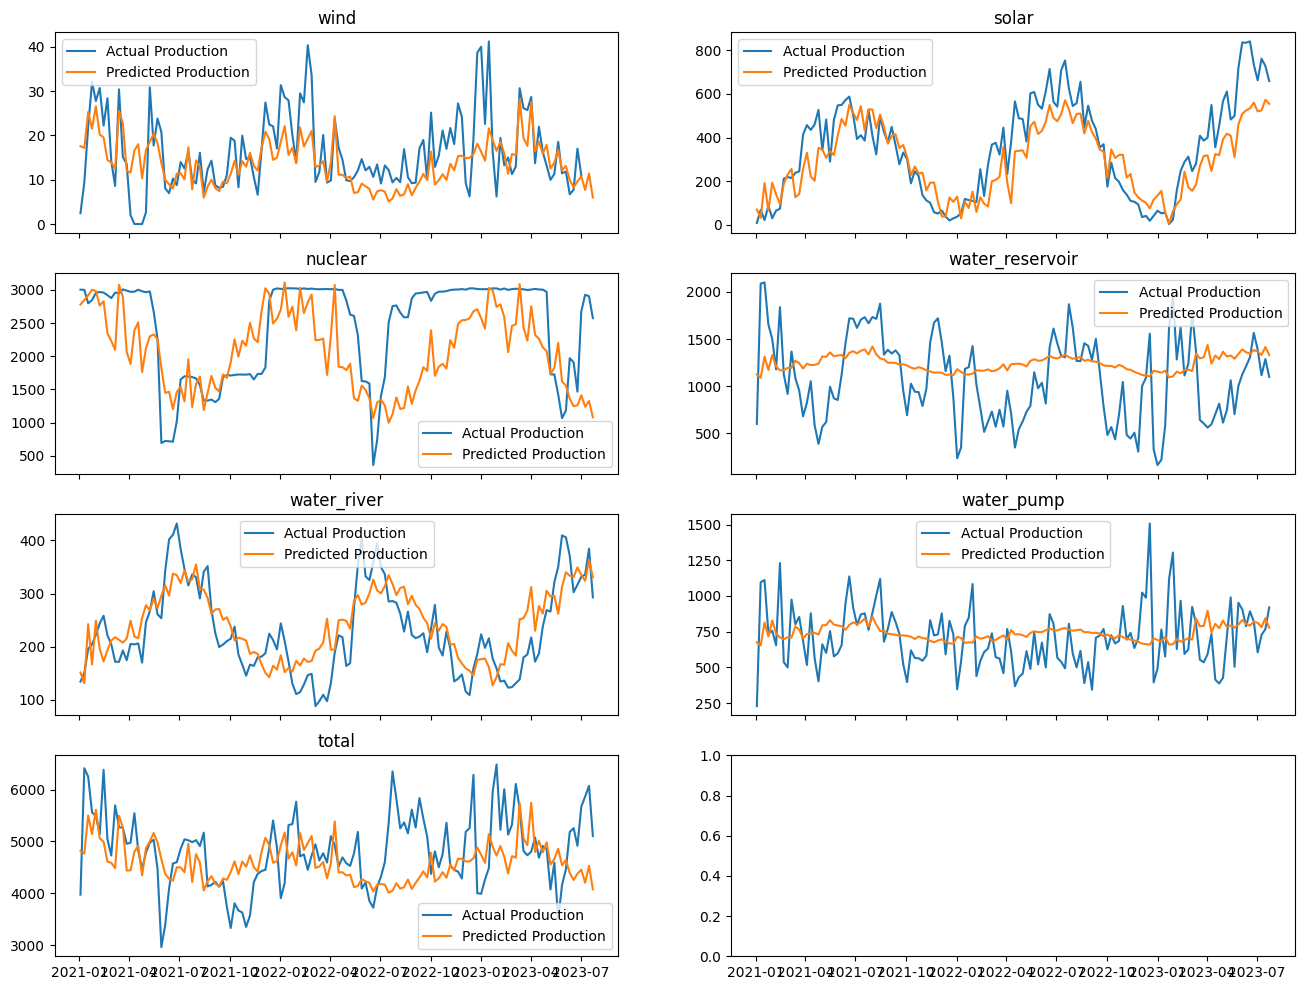

In [38]:
fig,axes = plt.subplots(4,2,figsize=(16,12),sharex=True)

for ax, col in zip(axes.ravel(),target_features.columns):
    ax.plot(target_features_weekly.loc[:,col], label="Actual Production")
    ax.plot(prediction_weekly.loc[:,col], label="Predicted Production")
    ax.set_title(col)
    ax.legend()

fig.savefig("../../src/sp_project/backend_server/static/pictures/overlap.png")

### Store the Model in a Pickle-File

In [41]:
if False:

    import pickle
    # Short-term-Storage of our model

    with open("../../src/sp_project/backend_server/assets/prediction-model.pickle", "wb") as fh:
        pickle.dump(dict(
            regressor = pls2,
            input_columns = input_features.columns,
            prediction_columns = target_features.columns,
        ), fh)

### Store Coefficients in a CSV-File

In [42]:
x_weights.to_csv('../../src/sp_project/backend_server/assets/x_weights.csv', index=True)
y_weights.to_csv('../../src/sp_project/backend_server/assets/y_weights.csv', index=True)

### Store Weather Features in a CSV-File

In [43]:
weather_features = round(input_features.resample("M").mean(), 3)
weather_features = weather_features.set_index(weather_features.index.date)
weather_features.index.name = "date"
weather_features.to_csv('../../src/sp_project/backend_server/assets/weatherfeatures.csv', index=True)

### Store Energy Features in a CSV

In [44]:
energy_features = round(target_features.resample("M").mean(), 3)
energy_features = energy_features.set_index(energy_features.index.date)
energy_features.index.name = "date"
energy_features.to_csv('../../src/sp_project/backend_server/assets/energyfeatures.csv', index=True)

## Jupyter-Notebook Footer-Info

In [45]:
import os
import platform
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 22.5.0
Datetime: 2023-07-25 09:44:05
Python Version: 3.11.4
-----------------------------------
